<a href="https://colab.research.google.com/github/upputurirajkumar/codEvo-solutions-Task2/blob/main/text_classification_with_Naive_Bayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from six.moves import range

# Setup Pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

# Setup Seaborn
sns.set_style("whitegrid")
sns.set_context("poster")

In [3]:
import pandas as pd
url ='https://raw.githubusercontent.com/Raizel820/Basic-Text-Classification-with-Naive-Bayes/master/critics.csv'
critics = pd.read_csv(url)
#let's drop rows with missing quotes
critics = critics[~critics.quote.isnull()]
critics.sample(10)

,critic,fresh,imdb,publication,quote,review_date,rtid,title
235,Bruce Reid,fresh,114388,Film.com,"Sense and Sensibility is funny, expansive, and...",2000-01-01,10042,Sense and Sensibility
22193,Robert Horton,fresh,128278,Film.com,Gooding is at his best!,2000-01-01,14302,Instinct
18203,Trevor Johnston,rotten,128442,Time Out,The end result is still short of a winning han...,2006-06-24,13868,Rounders
6212,Janet Maslin,fresh,83511,New York Times,[It] is more memorable for its characters than...,2004-08-30,13379,48 Hrs.
14593,Terry Lawson,rotten,315297,Detroit Free Press,The script is credited to Sarah Thorp but has ...,2004-02-27,14784,Twisted
211,Hal Hinson,rotten,112641,Washington Post,"Scorsese may be flailing here, but Scorsese fl...",2006-08-09,13456,Casino
24287,James Berardinelli,fresh,86200,ReelViews,"For writer/director Paul Brickman, this was a ...",2009-04-30,13296,Risky Business
8361,Variety Staff,fresh,26029,Variety,It's melodrama and at times far-fetched and im...,2008-08-18,17244,The 39 Steps
9473,Rene Rodriguez,fresh,272338,Miami Herald,Punch-Drunk Love knows how to reap epic deligh...,2002-10-25,13508,Punch-Drunk Love
17339,Jan Stuart,fresh,1075417,Washington Post,"The movie has Johnson, who lifts the script ab...",2009-03-13,770685949,Race to Witch Mountain


In [4]:
n_reviews = len(critics)
n_movies = critics.rtid.unique().size
n_critics = critics.critic.unique().size


print("Number of reviews: {:d}".format(n_reviews))
print("Number of critics: {:d}".format(n_critics))
print("Number of movies:  {:d}".format(n_movies))

Number of reviews: 15561
Number of critics: 623
Number of movies:  1921


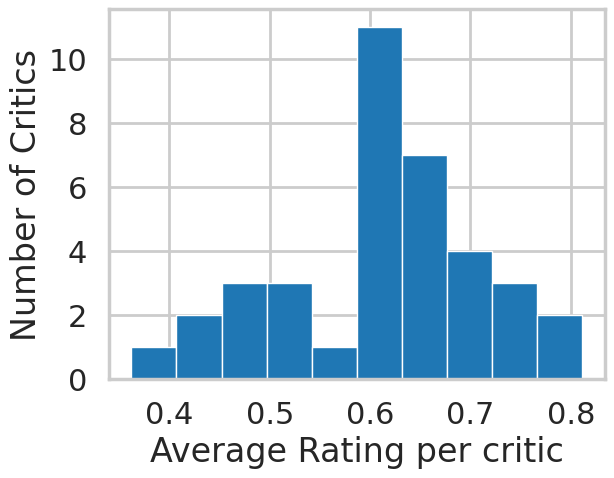

In [5]:
df = critics.copy()
df['fresh'] = df.fresh == 'fresh'
grp = df.groupby('critic')
counts = grp.critic.count()  # number of reviews by each critic
means = grp.fresh.mean()     # average freshness for each critic

means[counts > 100].hist(bins=10, edgecolor='w', lw=1)
plt.xlabel("Average Rating per critic")
plt.ylabel("Number of Critics")
plt.yticks([0, 2, 4, 6, 8, 10]);

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

text = ['Hop on pop', 'Hop off pop', 'Hop Hop hop']
print("Original text is\n{}".format('\n'.join(text)))

vectorizer = CountVectorizer()
vectorizer.fit(text)

x = vectorizer.transform(text)
x = x.toarray()

print("")
print("Transformed text vector is \n{}".format(x))
print("")
print("Words for each feature:")
print(vectorizer.get_feature_names_out())


Original text is
Hop on pop
Hop off pop
Hop Hop hop

Transformed text vector is 
[[1 0 1 1]
 [1 1 0 1]
 [3 0 0 0]]

Words for each feature:
['hop' 'off' 'on' 'pop']


In [11]:
def make_xy(critics, vectorizer=None):
    if vectorizer is None:
        vectorizer = CountVectorizer()
    X = vectorizer.fit_transform(critics.quote)
    X = X.tocsc()  # some versions of sklearn return COO format
    y = (critics.fresh == 'fresh').values.astype(int)  # Use int instead of np.int
    return X, y

In [34]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

# Assuming 'critics' is a DataFrame containing movie reviews, create X and y
X, y = make_xy(critics)  # Call make_xy to generate X and y

xtrain, xtest, ytrain, ytest = train_test_split(X, y)
clf = MultinomialNB().fit(xtrain, ytrain)
print("MN Accuracy: %0.2f%%" % (100 * clf.score(xtest, ytest)))

MN Accuracy: 77.74%


In [37]:
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: %0.2f" % (training_accuracy))
print("Accuracy on test data:     %0.2f" % (test_accuracy))

Accuracy on training data: 0.92
Accuracy on test data:     0.78


In [38]:
xtrain

<11670x22417 sparse matrix of type '<class 'numpy.int64'>'
	with 203796 stored elements in Compressed Sparse Row format>

In [39]:
from sklearn.model_selection import KFold
def cv_score(clf, X, y, scorefunc):
    result = 0.
    nfold = 5
    for train, test in KFold(nfold).split(X): # split data into train/test groups, 5 times
        clf.fit(X[train], y[train]) # fit the classifier, passed is as clf.
        result += scorefunc(clf, X[test], y[test]) # evaluate score function on held-out data
    return result / nfold # average

In [40]:
def log_likelihood(clf, x, y):
    prob = clf.predict_log_proba(x)
    rotten = y == 0
    fresh = ~rotten
    return prob[rotten, 0].sum() + prob[fresh, 1].sum()

In [43]:
from sklearn.model_selection import train_test_split
_, itest = train_test_split(range(critics.shape[0]), train_size=0.7)
mask = np.zeros(critics.shape[0], dtype=bool) # Use bool instead of np.bool
mask[itest] = True

In [44]:
#the grid of parameters to search over
alphas = [0, .1, 1, 5, 10, 50]
min_dfs = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

#Find the best value for alpha and min_df, and the best classifier
best_alpha = None
best_min_df = None
maxscore=-np.inf
for alpha in alphas:
    for min_df in min_dfs:
        vectorizer = CountVectorizer(min_df = min_df)
        Xthis, ythis = make_xy(critics, vectorizer)
        Xtrainthis=Xthis[mask]
        ytrainthis=ythis[mask]
        clf = MultinomialNB(alpha=alpha)
        cvscore = cv_score(clf, Xtrainthis, ytrainthis, log_likelihood)

        if cvscore > maxscore:
            maxscore = cvscore
            best_alpha, best_min_df = alpha, min_df

/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:629: FutureWarning: The default value for `force_alpha` will change to `True` in 1.4. To suppress this warning, manually set the value of `force_alpha`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:635: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10. Use `force_alpha=True` to keep alpha unchanged.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/naive_bayes.py:629: FutureWarning: The default val

In [46]:
print("alpha: %f" % best_alpha)
print("min_df: %f" % best_min_df)

alpha: 5.000000
min_df: 0.001000


In [47]:
print("alpha: {}".format(best_alpha))

alpha: 5


In [48]:
vectorizer = CountVectorizer(min_df=best_min_df)
X, y = make_xy(critics, vectorizer)
xtrain=X[mask]
ytrain=y[mask]
xtest=X[~mask]
ytest=y[~mask]

clf = MultinomialNB(alpha=best_alpha).fit(xtrain, ytrain)

#your turn. Print the accuracy on the test and training dataset
training_accuracy = clf.score(xtrain, ytrain)
test_accuracy = clf.score(xtest, ytest)

print("Accuracy on training data: {:2f}".format(training_accuracy))
print("Accuracy on test data:     {:2f}".format(test_accuracy))

Accuracy on training data: 0.806383
Accuracy on test data:     0.719152


In [49]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(ytest, clf.predict(xtest)))

[[2084 2172]
 [ 887 5749]]


In [51]:
words = np.array(vectorizer.get_feature_names_out()) # Use get_feature_names_out()

x = np.eye(xtest.shape[1])
probs = clf.predict_log_proba(x)[:, 0]
ind = np.argsort(probs)

good_words = words[ind[:10]]
bad_words = words[ind[-10:]]

good_prob = probs[ind[:10]]
bad_prob = probs[ind[-10:]]

print("Good words\t     P(fresh | word)")
for w, p in zip(good_words, good_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

print("Bad words\t     P(fresh | word)")
for w, p in zip(bad_words, bad_prob):
    print("{:>20}".format(w), "{:.2f}".format(1 - np.exp(p)))

Good words	     P(fresh | word)
        entertaining 0.88
          impressive 0.84
         intelligent 0.84
               years 0.84
            powerful 0.83
         performance 0.83
              beauty 0.83
         masterpiece 0.83
            touching 0.82
             perfect 0.82
Bad words	     P(fresh | word)
             muddled 0.30
          uninspired 0.30
                dull 0.29
             trouble 0.28
              barely 0.28
       unfortunately 0.28
               lacks 0.28
           pointless 0.26
               video 0.25
             numbers 0.25


In [52]:
x, y = make_xy(critics, vectorizer)

prob = clf.predict_proba(x)[:, 0]
predict = clf.predict(x)

bad_rotten = np.argsort(prob[y == 0])[:5]
bad_fresh = np.argsort(prob[y == 1])[-5:]

print("Mis-predicted Rotten quotes")
print('---------------------------')
for row in bad_rotten:
    print(critics[y == 0].quote.iloc[row])
    print("")

print("Mis-predicted Fresh quotes")
print('--------------------------')
for row in bad_fresh:
    print(critics[y == 1].quote.iloc[row])
    print("")

Mis-predicted Rotten quotes
---------------------------
The plot of The Glimmer Man involves not only the Family Man but Our Evil Secret Government, the Russian Mafia and Rich Powerful Politicians -- the three stooges of action cinema in the '90s.

Part comedy, part family drama, part romance, part special-effects mystery-adventure, and not entirely satisfying on any of these levels.

Benefits from a lively lead performance by the miscast Denzel Washington but doesn't come within light years of the book, one of the greatest American autobiographies.

It's a sad day when an actor who's totally, beautifully in touch with his dark side finds himself stuck in a movie that's scared of its own shadow.

It is sometimes funny in a puzzling kind of way, it is generally overwrought in an irritating kind of way, and once in a while it is inappropriately touching.

Mis-predicted Fresh quotes
--------------------------
Though it's a good half hour too long, this overblown 1993 spin-off of the 60s T

In [53]:
clf.predict_proba(vectorizer.transform(['This movie is not remarkable, touching, or superb in any way']))

array([[0.05568316, 0.94431684]])

In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectorizer = TfidfVectorizer(min_df=1, stop_words='english')
Xtfidf=tfidfvectorizer.fit_transform(critics.quote)

In [55]:
Xtfidf[0].toarray()

array([[0., 0., 0., ..., 0., 0., 0.]])

In [56]:
Xtfidf.shape

(15561, 22125)

In [57]:
import gensim

In [58]:
vectorizer = CountVectorizer(min_df=1, stop_words='english')
X=vectorizer.fit_transform(critics.quote)

In [60]:
corpus=vectorizer.get_feature_names_out() # Use get_feature_names_out() instead of get_feature_names()
id2words = dict((v, k) for k, v in vectorizer.vocabulary_.items()) # Use .items() instead of .iteritems() for compatibility
corpus_gensim = gensim.matutils.Sparse2Corpus(X, documents_columns=False)

In [61]:
lda = gensim.models.ldamodel.LdaModel(corpus_gensim, id2word=id2words, num_topics=5, update_every=1, chunksize=1000, passes=1)

In [62]:
lda.print_topics()

[(0,
  '0.017*"movie" + 0.010*"film" + 0.008*"funny" + 0.006*"little" + 0.005*"like" + 0.004*"story" + 0.004*"performances" + 0.004*"isn" + 0.004*"just" + 0.003*"compelling"'),
 (1,
  '0.014*"film" + 0.013*"movie" + 0.009*"comedy" + 0.008*"best" + 0.005*"new" + 0.005*"funny" + 0.005*"ve" + 0.005*"world" + 0.004*"year" + 0.004*"like"'),
 (2,
  '0.019*"film" + 0.010*"good" + 0.010*"movie" + 0.005*"really" + 0.005*"make" + 0.005*"great" + 0.004*"self" + 0.004*"big" + 0.004*"just" + 0.004*"bad"'),
 (3,
  '0.014*"film" + 0.014*"movie" + 0.008*"time" + 0.008*"director" + 0.007*"like" + 0.006*"characters" + 0.005*"story" + 0.005*"fun" + 0.005*"character" + 0.005*"make"'),
 (4,
  '0.013*"movie" + 0.007*"film" + 0.005*"comedy" + 0.005*"effects" + 0.004*"gone" + 0.004*"sweet" + 0.004*"low" + 0.004*"special" + 0.003*"look" + 0.003*"hilarious"')]